In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from glob import glob

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
from aggmap import show
np.random.seed(666) #just for reaptable results


In [2]:
flist = glob('../data/*.csv.gzip')
flist = pd.Series(flist).sort_values().tolist()
fall = []
for i in flist:
    df1 = pd.read_csv(i, compression='gzip', index_col = 0)
    df1['class'] = i.split('/')[-1].split('.csv')[0]
    fall.append(df1)
    
df = pd.concat(fall, axis=0)

In [3]:
dfx = df[df.columns[:-1]]
dfy = df[df.columns[-1:]]
dfx = np.log2(dfx + 1) #apply log2(x + 1)

In [4]:
scale_method = 'minmax'
mp = loadmap('../pan-cancer.mp')
X = mp.batch_transform(dfx.values, scale_method = scale_method) 
Y = pd.get_dummies(dfy['class']).values

100%|##########| 10446/10446 [24:21<00:00,  7.15it/s]


In [5]:
mp.fmap_shape

(102, 102)

In [6]:
dfy.shape, dfx.shape

((10446, 1), (10446, 10381))

In [7]:
class_ = pd.get_dummies(dfy['class']).columns
class_

Index(['01_ACC', '02_BLCA', '03_BRCA', '04_CESC', '05_CHOL', '06_COAD',
       '07_DLBC', '08_ESCA', '09_GBM', '10_HNSC', '11_KICH', '12_KIRC',
       '13_KIRP', '14_LAML', '15_LGG', '16_LIHC', '17_LUAD', '18_LUSC',
       '19_MESO', '20_OV', '21_PAAD', '22_PCPG', '23_PRAD', '24_READ',
       '25_SARC', '26_SKCM', '27_STAD', '28_TGCT', '29_THCA', '30_THYM',
       '31_UCEC', '32_UCS', '33_UVM'],
      dtype='object')

## feature maps

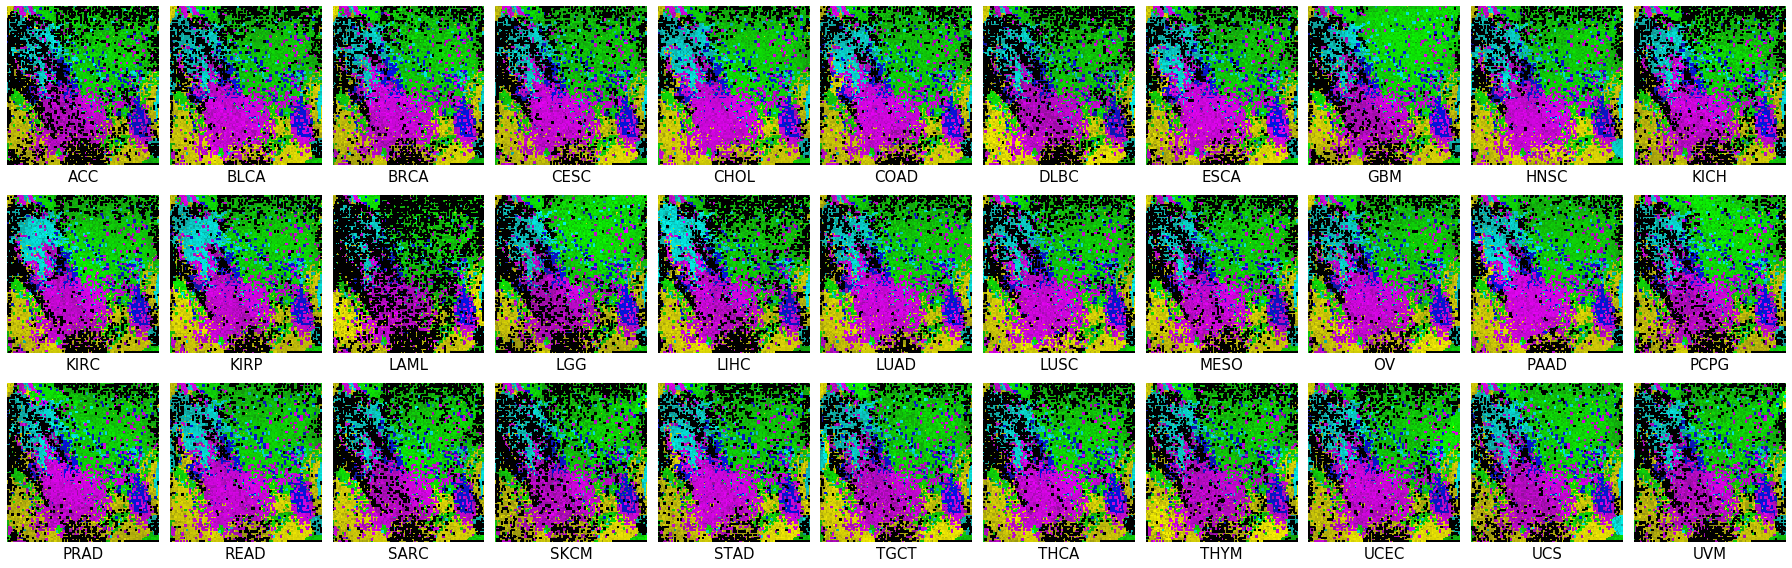

In [8]:
idx = dfy.reset_index().groupby('class').apply(lambda x:x.index.tolist())
rows = idx.index.tolist()
fontsize = 15
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(25, 8), sharex = True, sharey = True)

for row, ax in zip(rows, axes.ravel()):
    pid = idx.loc[row][0]  
    pid_name = row.split('_')[-1]
    x = X[pid]
    #ax.imshow(x.sum(axis=-1))
    show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=1) #
    ax.set_xlabel(pid_name, fontsize = fontsize) 

fig.tight_layout()
fig.savefig('./fmp-5.png', bbox_inches='tight', dpi=400) 
# fig.savefig('./fmp.svg', bbox_inches='tight', dpi=400) 

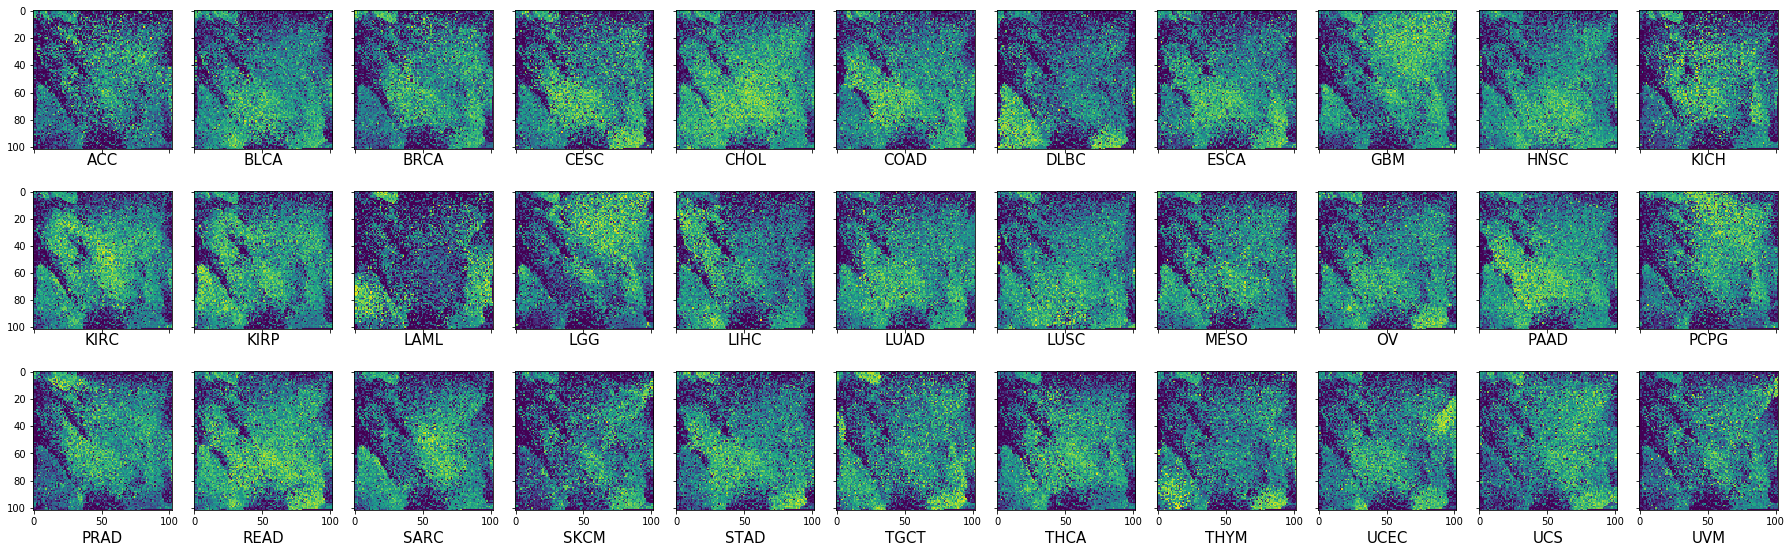

In [9]:
idx = dfy.reset_index().groupby('class').apply(lambda x:x.index.tolist())
rows = idx.index.tolist()
fontsize = 15
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(25, 8), sharex = True, sharey = True)

for row, ax in zip(rows, axes.ravel()):
    pid = idx.loc[row][0]  
    pid_name = row.split('_')[-1]
    x = X[pid]
    ax.imshow(x.sum(axis=-1))
    #show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=0.5) #
    ax.set_xlabel(pid_name, fontsize = fontsize) 

fig.tight_layout()
fig.savefig('./fmp.png', bbox_inches='tight', dpi=400) 
# fig.savefig('./fmp.svg', bbox_inches='tight', dpi=400) 

## 10 fold cv performances 

In [10]:
outer_fold = 10
# n, w,h,c = X.shape
# X1 = X.sum(axis=-1).reshape(n,w,h,1)

each_fold_results = []
outer = StratifiedKFold(n_splits = outer_fold, shuffle = True, random_state = 1)
outer_idx = outer.split(X, dfy.values)

print('#'*50  )
run_one_res = []
for i, idx in enumerate(outer_idx):

    fold_num = "fold_%s" % str(i).zfill(2) 

    save_path = './fold_resulst/%s' % fold_num
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    train_idx, test_idx = idx

    testY = Y[test_idx]
    testX = X[test_idx]

    trainX = X[train_idx]
    trainY = Y[train_idx]

    test_true_label = pd.DataFrame(testY).idxmax(axis=1).to_frame(name = 'y_true')
    test_true_label.index = dfy.iloc[test_idx].index
    test_true_label = test_true_label.join(dfy.iloc[test_idx])
    test_true_label.to_csv(os.path.join(save_path, 'test_true_label.csv'))


    print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

    clf = AggModel.MultiClassEstimator(epochs = 100, batch_size = 64, lr = 1e-3,  
                                       gpuid = 6, verbose = 1, metric = 'ACC', ) #
    clf.fit(trainX, trainY) 

    clf._model.save(os.path.join(save_path, 'model.h5'))
    
    test_pred_label = pd.DataFrame(clf.predict(testX)).idxmax(axis=1).to_frame(name = 'y_pred')
    test_pred_label.index = test_true_label.index
    test_pred_label.to_csv(os.path.join(save_path, 'test_pred_label.csv'))

    test_avg_loss, test_avg_acc = clf._model.evaluate(testX, testY, verbose=0)
    print('test_avg_loss: %.3f, test_avg_acc: %.3f, ' % (test_avg_loss, test_avg_acc))

    each_fold_results.append(test_avg_acc)

##################################################

 input train and test X shape is (9401, 102, 102, 5), (1045, 102, 102, 5) 
MultiClassEstimator(batch_size=64, epochs=100, gpuid='6', lr=0.001,
                    metric='ACC', verbose=1)
Train on 9401 samples, validate on 9401 samples
Epoch 1/100
9401/9401 [==============================] - 21s 2ms/sample - loss: 1.8998 - accuracy: 0.4771 - val_loss: 0.8611 - val_accuracy: 0.7507
Epoch 2/100
9401/9401 [==============================] - 17s 2ms/sample - loss: 0.6354 - accuracy: 0.8151 - val_loss: 0.4446 - val_accuracy: 0.8733
Epoch 3/100
9401/9401 [==============================] - 17s 2ms/sample - loss: 0.3671 - accuracy: 0.8902 - val_loss: 0.3015 - val_accuracy: 0.9105
Epoch 4/100
9401/9401 [==============================] - 17s 2ms/sample - loss: 0.3146 - accuracy: 0.9015 - val_loss: 0.2295 - val_accuracy: 0.9306
Epoch 5/100
9401/9401 [==============================] - 16s 2ms/sample - loss: 0.2518 - accuracy: 0.9176 - val_loss: 0.